## Environment Setting

In [1]:
# %pip install pandas==1.4.4
# %pip install numpy==1.26.1
# %pip install matplotlib
# %pip install seaborn
# %pip install statsmodels
# %pip install xgboost
# %pip install tqdm
# %pip install h3

In [2]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import xgboost

from tqdm import tqdm

print("pandas version:", pd.__version__)
print("numpy version:", np.__version__)
print("matplotlib version:", matplotlib.__version__)
print("seaborn version:", sns.__version__)
print("statsmodels version:", statsmodels.__version__)
print("xgboost version:", xgboost.__version__)

pandas version: 1.4.4
numpy version: 1.26.1
matplotlib version: 3.8.0
seaborn version: 0.13.0
statsmodels version: 0.14.0
xgboost version: 2.0.1


## 1. Import Data

In [3]:
ampeak = pd.read_csv('ampeak.csv')
pmpeak = pd.read_csv('pmpeak.csv')
nonpeak = pd.read_csv('nonpeak.csv')

In [4]:
poi = pd.read_csv('poi_processed.csv')
landuse = pd.read_csv('landuse_processed.csv')
bus_station = pd.read_csv('bus_station_processed.csv')
subway_station = pd.read_csv('subway_station_processed.csv')
impedance = pd.read_csv('impedance_processed.csv')

print(poi.shape, landuse.shape, bus_station.shape, subway_station.shape, impedance.shape)

(91, 7) (91, 6) (91, 4) (91, 2) (91, 91)


In [5]:
ind_var = pd.concat([poi, landuse, bus_station, subway_station], axis=1)
ind_var.drop(columns=['h8'], inplace=True)
ind_var

,High_School,Kindergarten,Middle_School,Elementary_School,Beach,Airport,Commercial,Green,Industrial,Others,Residential,Landuse_Mix,Feeder,Trunk,Other_Buses,Subway_Station
0,0.0,0.0,0.0,0.0,0.0,0,0.000,33841.944500,0.000,15621.208833,0.000000,0.348079,0.000000,4.000000,5.000000,1.235629
1,0.0,0.0,0.0,0.0,0.0,0,0.000,1463.542651,0.000,4853.298125,0.000000,0.302110,0.857143,0.000000,0.714286,2.155190
2,0.0,0.0,0.0,0.0,0.0,0,0.000,18512.543519,0.000,0.000000,0.000000,-0.000000,0.000000,0.000000,1.000000,1.865213
3,0.0,0.0,0.0,0.0,0.0,1,0.000,125006.501750,0.000,0.000000,0.000000,-0.000000,0.000000,4.000000,5.000000,0.611276
4,0.0,0.0,0.0,0.0,0.0,0,0.000,8220.935500,1979.149,5470.009571,0.000000,0.539770,0.000000,1.000000,0.000000,1.786583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,0.0,0.0,0.0,0.0,0.0,0,0.000,1926.171965,0.000,176.518000,0.000000,0.160908,2.000000,2.000000,0.000000,0.728563
87,0.0,0.0,0.0,0.0,0.0,0,0.000,647.727832,0.000,194.687389,0.000000,0.301720,1.500000,1.000000,0.000000,0.887165
88,0.0,0.0,0.0,1.0,0.0,0,0.000,604.766981,0.000,544.946667,0.000000,0.386097,6.000000,4.500000,0.000000,0.279181
89,0.0,0.0,0.0,0.0,0.0,0,554.804,1512.518205,0.000,0.000000,897.435622,0.568550,2.000000,1.333333,0.000000,1.515195


In [6]:
pd.set_option('display.max_columns', None)

ampeak = ampeak.merge(ind_var, how='left', left_on='Boarding', right_index=True).merge(ind_var, how='right', left_on='Alighting', right_index=True, suffixes=('_boarding', '_alighting'))
ampeak['impedance'] = ampeak.apply(lambda rows: impedance.iloc[int(rows['Boarding']), int(rows['Alighting'])], axis=1)
ampeak = ampeak.loc[ampeak['Boarding'] != ampeak['Alighting'], :]
ampeak.drop(columns=['Boarding', 'Alighting'], inplace=True)
ampeak

,Npgrs,High_School_boarding,Kindergarten_boarding,Middle_School_boarding,Elementary_School_boarding,Beach_boarding,Airport_boarding,Commercial_boarding,Green_boarding,Industrial_boarding,Others_boarding,Residential_boarding,Landuse_Mix_boarding,Feeder_boarding,Trunk_boarding,Other_Buses_boarding,Subway_Station_boarding,High_School_alighting,Kindergarten_alighting,Middle_School_alighting,Elementary_School_alighting,Beach_alighting,Airport_alighting,Commercial_alighting,Green_alighting,Industrial_alighting,Others_alighting,Residential_alighting,Landuse_Mix_alighting,Feeder_alighting,Trunk_alighting,Other_Buses_alighting,Subway_Station_alighting,impedance
91,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000,1463.542651,0.00000,4853.298125,0.000000,0.302110,0.857143,0.000000,0.714286,2.155190,0.0,0.0,0.0,0.0,0.0,0,0.0,33841.944500,0.0,15621.208833,0.0,0.348079,0.0,4.0,5.0,1.235629,2.959541
182,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000,18512.543519,0.00000,0.000000,0.000000,-0.000000,0.000000,0.000000,1.000000,1.865213,0.0,0.0,0.0,0.0,0.0,0,0.0,33841.944500,0.0,15621.208833,0.0,0.348079,0.0,4.0,5.0,1.235629,2.894677
273,0.0,0.0,0.0,0.0,0.0,0.0,1,0.000,125006.501750,0.00000,0.000000,0.000000,-0.000000,0.000000,4.000000,5.000000,0.611276,0.0,0.0,0.0,0.0,0.0,0,0.0,33841.944500,0.0,15621.208833,0.0,0.348079,0.0,4.0,5.0,1.235629,1.277682
364,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000,8220.935500,1979.14900,5470.009571,0.000000,0.539770,0.000000,1.000000,0.000000,1.786583,0.0,0.0,0.0,0.0,0.0,0,0.0,33841.944500,0.0,15621.208833,0.0,0.348079,0.0,4.0,5.0,1.235629,4.835468
455,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000,9495.465053,10975.16912,2793.558474,0.000000,0.543989,0.000000,1.000000,0.000000,1.752387,0.0,0.0,0.0,0.0,0.0,0,0.0,33841.944500,0.0,15621.208833,0.0,0.348079,0.0,4.0,5.0,1.235629,4.530795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7825,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000,942.436871,2747.82300,1989.058500,0.000000,0.567471,2.000000,0.000000,0.000000,1.977190,0.0,0.0,0.0,0.0,0.0,0,0.0,1126.313684,0.0,310.919000,0.0,0.291460,2.0,0.0,0.0,1.319791,0.691556
7916,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000,1926.171965,0.00000,176.518000,0.000000,0.160908,2.000000,2.000000,0.000000,0.728563,0.0,0.0,0.0,0.0,0.0,0,0.0,1126.313684,0.0,310.919000,0.0,0.291460,2.0,0.0,0.0,1.319791,0.691658
8007,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000,647.727832,0.00000,194.687389,0.000000,0.301720,1.500000,1.000000,0.000000,0.887165,0.0,0.0,0.0,0.0,0.0,0,0.0,1126.313684,0.0,310.919000,0.0,0.291460,2.0,0.0,0.0,1.319791,0.809964
8098,0.0,0.0,0.0,0.0,1.0,0.0,0,0.000,604.766981,0.00000,544.946667,0.000000,0.386097,6.000000,4.500000,0.000000,0.279181,0.0,0.0,0.0,0.0,0.0,0,0.0,1126.313684,0.0,310.919000,0.0,0.291460,2.0,0.0,0.0,1.319791,1.279270


In [7]:
pmpeak = pmpeak.merge(ind_var, how='left', left_on='Boarding', right_index=True).merge(ind_var, how='right', left_on='Alighting', right_index=True, suffixes=('_boarding', '_alighting'))
pmpeak['impedance'] = pmpeak.apply(lambda rows: impedance.iloc[int(rows['Boarding']), int(rows['Alighting'])], axis=1)
pmpeak = pmpeak.loc[pmpeak['Boarding'] != pmpeak['Alighting'], :]
pmpeak.drop(columns=['Boarding', 'Alighting'], inplace=True)
pmpeak

,Npgrs,High_School_boarding,Kindergarten_boarding,Middle_School_boarding,Elementary_School_boarding,Beach_boarding,Airport_boarding,Commercial_boarding,Green_boarding,Industrial_boarding,Others_boarding,Residential_boarding,Landuse_Mix_boarding,Feeder_boarding,Trunk_boarding,Other_Buses_boarding,Subway_Station_boarding,High_School_alighting,Kindergarten_alighting,Middle_School_alighting,Elementary_School_alighting,Beach_alighting,Airport_alighting,Commercial_alighting,Green_alighting,Industrial_alighting,Others_alighting,Residential_alighting,Landuse_Mix_alighting,Feeder_alighting,Trunk_alighting,Other_Buses_alighting,Subway_Station_alighting,impedance
91,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000,1463.542651,0.00000,4853.298125,0.000000,0.302110,0.857143,0.000000,0.714286,2.155190,0.0,0.0,0.0,0.0,0.0,0,0.0,33841.944500,0.0,15621.208833,0.0,0.348079,0.0,4.0,5.0,1.235629,2.959541
182,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000,18512.543519,0.00000,0.000000,0.000000,-0.000000,0.000000,0.000000,1.000000,1.865213,0.0,0.0,0.0,0.0,0.0,0,0.0,33841.944500,0.0,15621.208833,0.0,0.348079,0.0,4.0,5.0,1.235629,2.894677
273,0.0,0.0,0.0,0.0,0.0,0.0,1,0.000,125006.501750,0.00000,0.000000,0.000000,-0.000000,0.000000,4.000000,5.000000,0.611276,0.0,0.0,0.0,0.0,0.0,0,0.0,33841.944500,0.0,15621.208833,0.0,0.348079,0.0,4.0,5.0,1.235629,1.277682
364,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000,8220.935500,1979.14900,5470.009571,0.000000,0.539770,0.000000,1.000000,0.000000,1.786583,0.0,0.0,0.0,0.0,0.0,0,0.0,33841.944500,0.0,15621.208833,0.0,0.348079,0.0,4.0,5.0,1.235629,4.835468
455,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000,9495.465053,10975.16912,2793.558474,0.000000,0.543989,0.000000,1.000000,0.000000,1.752387,0.0,0.0,0.0,0.0,0.0,0,0.0,33841.944500,0.0,15621.208833,0.0,0.348079,0.0,4.0,5.0,1.235629,4.530795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7825,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000,942.436871,2747.82300,1989.058500,0.000000,0.567471,2.000000,0.000000,0.000000,1.977190,0.0,0.0,0.0,0.0,0.0,0,0.0,1126.313684,0.0,310.919000,0.0,0.291460,2.0,0.0,0.0,1.319791,0.691556
7916,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000,1926.171965,0.00000,176.518000,0.000000,0.160908,2.000000,2.000000,0.000000,0.728563,0.0,0.0,0.0,0.0,0.0,0,0.0,1126.313684,0.0,310.919000,0.0,0.291460,2.0,0.0,0.0,1.319791,0.691658
8007,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000,647.727832,0.00000,194.687389,0.000000,0.301720,1.500000,1.000000,0.000000,0.887165,0.0,0.0,0.0,0.0,0.0,0,0.0,1126.313684,0.0,310.919000,0.0,0.291460,2.0,0.0,0.0,1.319791,0.809964
8098,0.0,0.0,0.0,0.0,1.0,0.0,0,0.000,604.766981,0.00000,544.946667,0.000000,0.386097,6.000000,4.500000,0.000000,0.279181,0.0,0.0,0.0,0.0,0.0,0,0.0,1126.313684,0.0,310.919000,0.0,0.291460,2.0,0.0,0.0,1.319791,1.279270


In [8]:
nonpeak = nonpeak.merge(ind_var, how='left', left_on='Boarding', right_index=True).merge(ind_var, how='right', left_on='Alighting', right_index=True, suffixes=('_boarding', '_alighting'))
nonpeak['impedance'] = nonpeak.apply(lambda rows: impedance.iloc[int(rows['Boarding']), int(rows['Alighting'])], axis=1)
nonpeak = nonpeak.loc[nonpeak['Boarding'] != nonpeak['Alighting'], :]
nonpeak.drop(columns=['Boarding', 'Alighting'], inplace=True)
nonpeak

,Npgrs,High_School_boarding,Kindergarten_boarding,Middle_School_boarding,Elementary_School_boarding,Beach_boarding,Airport_boarding,Commercial_boarding,Green_boarding,Industrial_boarding,Others_boarding,Residential_boarding,Landuse_Mix_boarding,Feeder_boarding,Trunk_boarding,Other_Buses_boarding,Subway_Station_boarding,High_School_alighting,Kindergarten_alighting,Middle_School_alighting,Elementary_School_alighting,Beach_alighting,Airport_alighting,Commercial_alighting,Green_alighting,Industrial_alighting,Others_alighting,Residential_alighting,Landuse_Mix_alighting,Feeder_alighting,Trunk_alighting,Other_Buses_alighting,Subway_Station_alighting,impedance
91,0.000000,0.0,0.0,0.0,0.0,0.0,0,0.000,1463.542651,0.00000,4853.298125,0.000000,0.302110,0.857143,0.000000,0.714286,2.155190,0.0,0.0,0.0,0.0,0.0,0,0.0,33841.944500,0.0,15621.208833,0.0,0.348079,0.0,4.0,5.0,1.235629,2.959541
182,0.000000,0.0,0.0,0.0,0.0,0.0,0,0.000,18512.543519,0.00000,0.000000,0.000000,-0.000000,0.000000,0.000000,1.000000,1.865213,0.0,0.0,0.0,0.0,0.0,0,0.0,33841.944500,0.0,15621.208833,0.0,0.348079,0.0,4.0,5.0,1.235629,2.894677
273,0.003332,0.0,0.0,0.0,0.0,0.0,1,0.000,125006.501750,0.00000,0.000000,0.000000,-0.000000,0.000000,4.000000,5.000000,0.611276,0.0,0.0,0.0,0.0,0.0,0,0.0,33841.944500,0.0,15621.208833,0.0,0.348079,0.0,4.0,5.0,1.235629,1.277682
364,0.000000,0.0,0.0,0.0,0.0,0.0,0,0.000,8220.935500,1979.14900,5470.009571,0.000000,0.539770,0.000000,1.000000,0.000000,1.786583,0.0,0.0,0.0,0.0,0.0,0,0.0,33841.944500,0.0,15621.208833,0.0,0.348079,0.0,4.0,5.0,1.235629,4.835468
455,0.000000,0.0,0.0,0.0,0.0,0.0,0,0.000,9495.465053,10975.16912,2793.558474,0.000000,0.543989,0.000000,1.000000,0.000000,1.752387,0.0,0.0,0.0,0.0,0.0,0,0.0,33841.944500,0.0,15621.208833,0.0,0.348079,0.0,4.0,5.0,1.235629,4.530795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7825,0.000000,0.0,0.0,0.0,0.0,0.0,0,0.000,942.436871,2747.82300,1989.058500,0.000000,0.567471,2.000000,0.000000,0.000000,1.977190,0.0,0.0,0.0,0.0,0.0,0,0.0,1126.313684,0.0,310.919000,0.0,0.291460,2.0,0.0,0.0,1.319791,0.691556
7916,0.000000,0.0,0.0,0.0,0.0,0.0,0,0.000,1926.171965,0.00000,176.518000,0.000000,0.160908,2.000000,2.000000,0.000000,0.728563,0.0,0.0,0.0,0.0,0.0,0,0.0,1126.313684,0.0,310.919000,0.0,0.291460,2.0,0.0,0.0,1.319791,0.691658
8007,0.000000,0.0,0.0,0.0,0.0,0.0,0,0.000,647.727832,0.00000,194.687389,0.000000,0.301720,1.500000,1.000000,0.000000,0.887165,0.0,0.0,0.0,0.0,0.0,0,0.0,1126.313684,0.0,310.919000,0.0,0.291460,2.0,0.0,0.0,1.319791,0.809964
8098,0.002291,0.0,0.0,0.0,1.0,0.0,0,0.000,604.766981,0.00000,544.946667,0.000000,0.386097,6.000000,4.500000,0.000000,0.279181,0.0,0.0,0.0,0.0,0.0,0,0.0,1126.313684,0.0,310.919000,0.0,0.291460,2.0,0.0,0.0,1.319791,1.279270


## 2. Descriptive Statistics

In [9]:
var_names = ['Residential', 'Commercial', 'Industrial', 'Green', 'Others', 'Landuse_Mix', 'Kindergarten', 'Elementary_School', 'Middle_School', 'High_School', 'Airport', 'Beach', 'Trunk', 'Feeder', 'Other_Buses', 'Subway_Station']

In [10]:
pd.concat([ind_var.describe()[var_names], impedance.unstack().describe().rename('impedance')], axis=1).T.to_csv('ind_var_describe.csv')
pd.concat([ind_var.describe()[var_names], impedance.unstack().describe().rename('impedance')], axis=1)

,Residential,Commercial,Industrial,Green,Others,Landuse_Mix,Kindergarten,Elementary_School,Middle_School,High_School,Airport,Beach,Trunk,Feeder,Other_Buses,Subway_Station,impedance
count,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,8281.000000
mean,1522.627985,542.973891,532.891273,9808.262115,4706.919504,0.352186,0.131868,0.131868,0.054945,0.076923,0.021978,0.032967,1.407686,1.476991,1.165327,2.482535,6.833600
std,3256.750344,1349.301962,2004.578099,19974.486890,28499.692492,0.204461,0.452371,0.400244,0.229135,0.372104,0.147424,0.179540,1.406696,1.230151,3.564431,1.427165,4.466670
min,0.000000,0.000000,0.000000,516.300682,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.249112,0.000000
25%,0.000000,0.000000,0.000000,1002.110294,0.000000,0.230518,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.828571,0.000000,1.268285,3.204926
50%,0.000000,0.000000,0.000000,2399.834950,419.430750,0.349252,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.200000,0.500000,2.317912,5.686496
75%,1089.671298,0.000000,0.000000,10534.969991,1506.580747,0.534796,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.166667,2.000000,1.000000,3.398919,10.374035
max,16552.619000,6552.680000,12383.902067,125027.479250,271616.564000,0.808825,3.000000,2.000000,1.000000,3.000000,1.000000,1.000000,6.000000,6.000000,33.000000,5.792440,18.812610


## 3. Multiplicative Model

In [11]:
# Reference code: https://signature95.tistory.com/18

def vif(x, thresh=10):
    output = pd.DataFrame()
    k = x.shape[1]

    vif_list = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
    for i in range(k):
        a = np.argmax(vif_list)

        if i == 0:
            print(f'Max VIF feature: {x.columns[a]}, VIF value: {np.round(vif_list[a], 3)}')

            if (vif_list[a] <= thresh):
                print('\n')
                for q in range(x.shape[1]):
                    print(f'VIF value of {x.columns[q]}: {np.round(vif_list[q], 3)}')

                output = x
                break
            else:
                output = x.drop(x.columns[a], axis = 1)
                vif_list = [variance_inflation_factor(output.values, j) for j in range(output.shape[1])]

        else:
            print(f'Max VIF feature: {output.columns[a]}, VIF value: {np.round(vif_list[a], 3)}')

            if (vif_list[a] <= thresh):
                print('\n')
                for q in range(output.shape[1]):
                    print(f'VIF value of {output.columns[q]}: {np.round(vif_list[q], 3)}')
                break
                    
            else:
                output = output.drop(output.columns[a], axis = 1)
                vif_list = [variance_inflation_factor(output.values, j) for j in range(output.shape[1])]

    return output, output.columns.to_list()

In [12]:
var_names = ['Residential', 'Commercial', 'Industrial', 'Green', 'Others', 'Landuse_Mix', 'Kindergarten', 'Elementary_School', 'Middle_School', 'High_School', 'Airport', 'Beach', 'Trunk', 'Feeder', 'Other_Buses', 'Subway_Station']
var_list = [i + '_' + j for i in var_names for j in ['boarding', 'alighting']] + ['impedance']

### 3.1. AM Peak Model

In [13]:
for i in ampeak.columns:
    ampeak.loc[ampeak[i] == 0, i] = 1e-03

ampeak

,Npgrs,High_School_boarding,Kindergarten_boarding,Middle_School_boarding,Elementary_School_boarding,Beach_boarding,Airport_boarding,Commercial_boarding,Green_boarding,Industrial_boarding,Others_boarding,Residential_boarding,Landuse_Mix_boarding,Feeder_boarding,Trunk_boarding,Other_Buses_boarding,Subway_Station_boarding,High_School_alighting,Kindergarten_alighting,Middle_School_alighting,Elementary_School_alighting,Beach_alighting,Airport_alighting,Commercial_alighting,Green_alighting,Industrial_alighting,Others_alighting,Residential_alighting,Landuse_Mix_alighting,Feeder_alighting,Trunk_alighting,Other_Buses_alighting,Subway_Station_alighting,impedance
91,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,1463.542651,0.00100,4853.298125,0.001000,0.302110,0.857143,0.001000,0.714286,2.155190,0.001,0.001,0.001,0.001,0.001,0.001,0.001,33841.944500,0.001,15621.208833,0.001,0.348079,0.001,4.000,5.000,1.235629,2.959541
182,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,18512.543519,0.00100,0.001000,0.001000,0.001000,0.001000,0.001000,1.000000,1.865213,0.001,0.001,0.001,0.001,0.001,0.001,0.001,33841.944500,0.001,15621.208833,0.001,0.348079,0.001,4.000,5.000,1.235629,2.894677
273,0.001,0.001,0.001,0.001,0.001,0.001,1.000,0.001,125006.501750,0.00100,0.001000,0.001000,0.001000,0.001000,4.000000,5.000000,0.611276,0.001,0.001,0.001,0.001,0.001,0.001,0.001,33841.944500,0.001,15621.208833,0.001,0.348079,0.001,4.000,5.000,1.235629,1.277682
364,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,8220.935500,1979.14900,5470.009571,0.001000,0.539770,0.001000,1.000000,0.001000,1.786583,0.001,0.001,0.001,0.001,0.001,0.001,0.001,33841.944500,0.001,15621.208833,0.001,0.348079,0.001,4.000,5.000,1.235629,4.835468
455,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,9495.465053,10975.16912,2793.558474,0.001000,0.543989,0.001000,1.000000,0.001000,1.752387,0.001,0.001,0.001,0.001,0.001,0.001,0.001,33841.944500,0.001,15621.208833,0.001,0.348079,0.001,4.000,5.000,1.235629,4.530795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7825,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,942.436871,2747.82300,1989.058500,0.001000,0.567471,2.000000,0.001000,0.001000,1.977190,0.001,0.001,0.001,0.001,0.001,0.001,0.001,1126.313684,0.001,310.919000,0.001,0.291460,2.000,0.001,0.001,1.319791,0.691556
7916,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,1926.171965,0.00100,176.518000,0.001000,0.160908,2.000000,2.000000,0.001000,0.728563,0.001,0.001,0.001,0.001,0.001,0.001,0.001,1126.313684,0.001,310.919000,0.001,0.291460,2.000,0.001,0.001,1.319791,0.691658
8007,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,647.727832,0.00100,194.687389,0.001000,0.301720,1.500000,1.000000,0.001000,0.887165,0.001,0.001,0.001,0.001,0.001,0.001,0.001,1126.313684,0.001,310.919000,0.001,0.291460,2.000,0.001,0.001,1.319791,0.809964
8098,0.001,0.001,0.001,0.001,1.000,0.001,0.001,0.001,604.766981,0.00100,544.946667,0.001000,0.386097,6.000000,4.500000,0.001000,0.279181,0.001,0.001,0.001,0.001,0.001,0.001,0.001,1126.313684,0.001,310.919000,0.001,0.291460,2.000,0.001,0.001,1.319791,1.279270


In [14]:
ampeak = ampeak.apply(lambda x: np.log(x))
ampeak

,Npgrs,High_School_boarding,Kindergarten_boarding,Middle_School_boarding,Elementary_School_boarding,Beach_boarding,Airport_boarding,Commercial_boarding,Green_boarding,Industrial_boarding,Others_boarding,Residential_boarding,Landuse_Mix_boarding,Feeder_boarding,Trunk_boarding,Other_Buses_boarding,Subway_Station_boarding,High_School_alighting,Kindergarten_alighting,Middle_School_alighting,Elementary_School_alighting,Beach_alighting,Airport_alighting,Commercial_alighting,Green_alighting,Industrial_alighting,Others_alighting,Residential_alighting,Landuse_Mix_alighting,Feeder_alighting,Trunk_alighting,Other_Buses_alighting,Subway_Station_alighting,impedance
91,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,7.288615,-6.907755,8.487414,-6.907755,-1.196963,-0.154151,-6.907755,-0.336472,0.767879,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,10.429456,-6.907755,9.656385,-6.907755,-1.055325,-6.907755,1.386294,1.609438,0.211580,1.085034
182,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,9.826204,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,0.000000,0.623375,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,10.429456,-6.907755,9.656385,-6.907755,-1.055325,-6.907755,1.386294,1.609438,0.211580,1.062874
273,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,0.000000,-6.907755,11.736121,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,1.386294,1.609438,-0.492207,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,10.429456,-6.907755,9.656385,-6.907755,-1.055325,-6.907755,1.386294,1.609438,0.211580,0.245048
364,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,9.014439,7.590422,8.607036,-6.907755,-0.616612,-6.907755,0.000000,-6.907755,0.580305,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,10.429456,-6.907755,9.656385,-6.907755,-1.055325,-6.907755,1.386294,1.609438,0.211580,1.575978
455,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,9.158570,9.303391,7.935072,-6.907755,-0.608826,-6.907755,0.000000,-6.907755,0.560979,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,10.429456,-6.907755,9.656385,-6.907755,-1.055325,-6.907755,1.386294,1.609438,0.211580,1.510897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7825,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,6.848469,7.918564,7.595417,-6.907755,-0.566566,0.693147,-6.907755,-6.907755,0.681677,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,7.026705,-6.907755,5.739532,-6.907755,-1.232853,0.693147,-6.907755,-6.907755,0.277473,-0.368812
7916,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,7.563290,-6.907755,5.173423,-6.907755,-1.826921,0.693147,0.693147,-6.907755,-0.316681,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,7.026705,-6.907755,5.739532,-6.907755,-1.232853,0.693147,-6.907755,-6.907755,0.277473,-0.368664
8007,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,6.473471,-6.907755,5.271395,-6.907755,-1.198256,0.405465,0.000000,-6.907755,-0.119724,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,7.026705,-6.907755,5.739532,-6.907755,-1.232853,0.693147,-6.907755,-6.907755,0.277473,-0.210766
8098,-6.907755,-6.907755,-6.907755,-6.907755,0.000000,-6.907755,-6.907755,-6.907755,6.404843,-6.907755,6.300688,-6.907755,-0.951667,1.791759,1.504077,-6.907755,-1.275895,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,7.026705,-6.907755,5.739532,-6.907755,-1.232853,0.693147,-6.907755,-6.907755,0.277473,0.246289


In [15]:
vif_am = pd.DataFrame()

vif_am["VIF Factor"] = [variance_inflation_factor(ampeak.values, i) for i in range(1, ampeak.shape[1])]
vif_am["features"] = ampeak.columns[1:]

vif_am = vif_am.sort_values(by="VIF Factor", ascending=False)
vif_am = vif_am.reset_index().drop(columns='index')
vif_am

,VIF Factor,features
0,63.991640,Green_alighting
1,63.703785,Green_boarding
2,58.850475,Airport_alighting
3,58.157143,Airport_boarding
4,35.655611,Beach_alighting
5,35.562177,Beach_boarding
6,23.512151,Middle_School_alighting
7,23.451506,Middle_School_boarding
8,22.043451,High_School_alighting
9,21.936218,High_School_boarding


In [16]:
ampeak_final, ampeak_list = vif(ampeak[var_list])

Max VIF feature: Green_boarding, VIF value: 63.465
Max VIF feature: Green_alighting, VIF value: 58.121
Max VIF feature: Airport_boarding, VIF value: 52.604
Max VIF feature: Airport_alighting, VIF value: 48.782
Max VIF feature: Beach_boarding, VIF value: 27.869
Max VIF feature: Beach_alighting, VIF value: 25.344
Max VIF feature: Middle_School_boarding, VIF value: 21.74
Max VIF feature: Middle_School_alighting, VIF value: 21.651
Max VIF feature: Kindergarten_boarding, VIF value: 16.182
Max VIF feature: Kindergarten_alighting, VIF value: 16.162
Max VIF feature: High_School_boarding, VIF value: 15.105
Max VIF feature: High_School_alighting, VIF value: 13.953
Max VIF feature: Elementary_School_alighting, VIF value: 8.091


VIF value of Residential_boarding: 2.052
VIF value of Residential_alighting: 2.052
VIF value of Commercial_boarding: 2.392
VIF value of Commercial_alighting: 2.392
VIF value of Industrial_boarding: 2.209
VIF value of Industrial_alighting: 2.209
VIF value of Others_boardin

In [17]:
ampeak_list

['Residential_boarding',
 'Residential_alighting',
 'Commercial_boarding',
 'Commercial_alighting',
 'Industrial_boarding',
 'Industrial_alighting',
 'Others_boarding',
 'Others_alighting',
 'Landuse_Mix_boarding',
 'Landuse_Mix_alighting',
 'Elementary_School_boarding',
 'Elementary_School_alighting',
 'Trunk_boarding',
 'Trunk_alighting',
 'Feeder_boarding',
 'Feeder_alighting',
 'Other_Buses_boarding',
 'Other_Buses_alighting',
 'Subway_Station_boarding',
 'Subway_Station_alighting',
 'impedance']

In [18]:
str = ''

for i in ampeak_list:
    str += i + '+'
    if i == 'impedance':
        str += i

str

'Residential_boarding+Residential_alighting+Commercial_boarding+Commercial_alighting+Industrial_boarding+Industrial_alighting+Others_boarding+Others_alighting+Landuse_Mix_boarding+Landuse_Mix_alighting+Elementary_School_boarding+Elementary_School_alighting+Trunk_boarding+Trunk_alighting+Feeder_boarding+Feeder_alighting+Other_Buses_boarding+Other_Buses_alighting+Subway_Station_boarding+Subway_Station_alighting+impedance+impedance'

In [19]:
ammodel = sm.OLS(ampeak['Npgrs'], sm.add_constant(ampeak_final))
amresult = ammodel.fit()
print(amresult.summary())

                            OLS Regression Results                            
Dep. Variable:                  Npgrs   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                  0.189
Method:                 Least Squares   F-statistic:                     92.00
Date:                Wed, 29 Nov 2023   Prob (F-statistic):               0.00
Time:                        18:45:09   Log-Likelihood:                -10904.
No. Observations:                8190   AIC:                         2.185e+04
Df Residuals:                    8168   BIC:                         2.201e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

### 3.2. PM Peak Model

In [20]:
for i in pmpeak.columns:
    pmpeak.loc[pmpeak[i] == 0, i] = 1e-03

pmpeak

,Npgrs,High_School_boarding,Kindergarten_boarding,Middle_School_boarding,Elementary_School_boarding,Beach_boarding,Airport_boarding,Commercial_boarding,Green_boarding,Industrial_boarding,Others_boarding,Residential_boarding,Landuse_Mix_boarding,Feeder_boarding,Trunk_boarding,Other_Buses_boarding,Subway_Station_boarding,High_School_alighting,Kindergarten_alighting,Middle_School_alighting,Elementary_School_alighting,Beach_alighting,Airport_alighting,Commercial_alighting,Green_alighting,Industrial_alighting,Others_alighting,Residential_alighting,Landuse_Mix_alighting,Feeder_alighting,Trunk_alighting,Other_Buses_alighting,Subway_Station_alighting,impedance
91,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,1463.542651,0.00100,4853.298125,0.001000,0.302110,0.857143,0.001000,0.714286,2.155190,0.001,0.001,0.001,0.001,0.001,0.001,0.001,33841.944500,0.001,15621.208833,0.001,0.348079,0.001,4.000,5.000,1.235629,2.959541
182,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,18512.543519,0.00100,0.001000,0.001000,0.001000,0.001000,0.001000,1.000000,1.865213,0.001,0.001,0.001,0.001,0.001,0.001,0.001,33841.944500,0.001,15621.208833,0.001,0.348079,0.001,4.000,5.000,1.235629,2.894677
273,0.001,0.001,0.001,0.001,0.001,0.001,1.000,0.001,125006.501750,0.00100,0.001000,0.001000,0.001000,0.001000,4.000000,5.000000,0.611276,0.001,0.001,0.001,0.001,0.001,0.001,0.001,33841.944500,0.001,15621.208833,0.001,0.348079,0.001,4.000,5.000,1.235629,1.277682
364,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,8220.935500,1979.14900,5470.009571,0.001000,0.539770,0.001000,1.000000,0.001000,1.786583,0.001,0.001,0.001,0.001,0.001,0.001,0.001,33841.944500,0.001,15621.208833,0.001,0.348079,0.001,4.000,5.000,1.235629,4.835468
455,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,9495.465053,10975.16912,2793.558474,0.001000,0.543989,0.001000,1.000000,0.001000,1.752387,0.001,0.001,0.001,0.001,0.001,0.001,0.001,33841.944500,0.001,15621.208833,0.001,0.348079,0.001,4.000,5.000,1.235629,4.530795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7825,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,942.436871,2747.82300,1989.058500,0.001000,0.567471,2.000000,0.001000,0.001000,1.977190,0.001,0.001,0.001,0.001,0.001,0.001,0.001,1126.313684,0.001,310.919000,0.001,0.291460,2.000,0.001,0.001,1.319791,0.691556
7916,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,1926.171965,0.00100,176.518000,0.001000,0.160908,2.000000,2.000000,0.001000,0.728563,0.001,0.001,0.001,0.001,0.001,0.001,0.001,1126.313684,0.001,310.919000,0.001,0.291460,2.000,0.001,0.001,1.319791,0.691658
8007,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,647.727832,0.00100,194.687389,0.001000,0.301720,1.500000,1.000000,0.001000,0.887165,0.001,0.001,0.001,0.001,0.001,0.001,0.001,1126.313684,0.001,310.919000,0.001,0.291460,2.000,0.001,0.001,1.319791,0.809964
8098,0.001,0.001,0.001,0.001,1.000,0.001,0.001,0.001,604.766981,0.00100,544.946667,0.001000,0.386097,6.000000,4.500000,0.001000,0.279181,0.001,0.001,0.001,0.001,0.001,0.001,0.001,1126.313684,0.001,310.919000,0.001,0.291460,2.000,0.001,0.001,1.319791,1.279270


In [21]:
pmpeak = pmpeak.apply(lambda x: np.log(x))
pmpeak

,Npgrs,High_School_boarding,Kindergarten_boarding,Middle_School_boarding,Elementary_School_boarding,Beach_boarding,Airport_boarding,Commercial_boarding,Green_boarding,Industrial_boarding,Others_boarding,Residential_boarding,Landuse_Mix_boarding,Feeder_boarding,Trunk_boarding,Other_Buses_boarding,Subway_Station_boarding,High_School_alighting,Kindergarten_alighting,Middle_School_alighting,Elementary_School_alighting,Beach_alighting,Airport_alighting,Commercial_alighting,Green_alighting,Industrial_alighting,Others_alighting,Residential_alighting,Landuse_Mix_alighting,Feeder_alighting,Trunk_alighting,Other_Buses_alighting,Subway_Station_alighting,impedance
91,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,7.288615,-6.907755,8.487414,-6.907755,-1.196963,-0.154151,-6.907755,-0.336472,0.767879,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,10.429456,-6.907755,9.656385,-6.907755,-1.055325,-6.907755,1.386294,1.609438,0.211580,1.085034
182,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,9.826204,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,0.000000,0.623375,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,10.429456,-6.907755,9.656385,-6.907755,-1.055325,-6.907755,1.386294,1.609438,0.211580,1.062874
273,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,0.000000,-6.907755,11.736121,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,1.386294,1.609438,-0.492207,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,10.429456,-6.907755,9.656385,-6.907755,-1.055325,-6.907755,1.386294,1.609438,0.211580,0.245048
364,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,9.014439,7.590422,8.607036,-6.907755,-0.616612,-6.907755,0.000000,-6.907755,0.580305,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,10.429456,-6.907755,9.656385,-6.907755,-1.055325,-6.907755,1.386294,1.609438,0.211580,1.575978
455,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,9.158570,9.303391,7.935072,-6.907755,-0.608826,-6.907755,0.000000,-6.907755,0.560979,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,10.429456,-6.907755,9.656385,-6.907755,-1.055325,-6.907755,1.386294,1.609438,0.211580,1.510897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7825,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,6.848469,7.918564,7.595417,-6.907755,-0.566566,0.693147,-6.907755,-6.907755,0.681677,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,7.026705,-6.907755,5.739532,-6.907755,-1.232853,0.693147,-6.907755,-6.907755,0.277473,-0.368812
7916,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,7.563290,-6.907755,5.173423,-6.907755,-1.826921,0.693147,0.693147,-6.907755,-0.316681,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,7.026705,-6.907755,5.739532,-6.907755,-1.232853,0.693147,-6.907755,-6.907755,0.277473,-0.368664
8007,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,6.473471,-6.907755,5.271395,-6.907755,-1.198256,0.405465,0.000000,-6.907755,-0.119724,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,7.026705,-6.907755,5.739532,-6.907755,-1.232853,0.693147,-6.907755,-6.907755,0.277473,-0.210766
8098,-6.907755,-6.907755,-6.907755,-6.907755,0.000000,-6.907755,-6.907755,-6.907755,6.404843,-6.907755,6.300688,-6.907755,-0.951667,1.791759,1.504077,-6.907755,-1.275895,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,7.026705,-6.907755,5.739532,-6.907755,-1.232853,0.693147,-6.907755,-6.907755,0.277473,0.246289


In [22]:
vif_pm = pd.DataFrame()

vif_pm["VIF Factor"] = [variance_inflation_factor(pmpeak.values, i) for i in range(1, pmpeak.shape[1])]
vif_pm["features"] = pmpeak.columns[1:]

vif_pm = vif_pm.sort_values(by="VIF Factor", ascending=False)
vif_pm = vif_pm.reset_index().drop(columns='index')
vif_pm

,VIF Factor,features
0,63.619700,Green_boarding
1,63.602086,Green_alighting
2,58.224166,Airport_boarding
3,58.181354,Airport_alighting
4,35.657634,Beach_alighting
5,35.626504,Beach_boarding
6,23.528392,Middle_School_alighting
7,23.426815,Middle_School_boarding
8,21.993668,High_School_boarding
9,21.833670,High_School_alighting


In [23]:
pmpeak_final, pmpeak_list = vif(pmpeak[var_list])

Max VIF feature: Green_boarding, VIF value: 63.465
Max VIF feature: Green_alighting, VIF value: 58.121
Max VIF feature: Airport_boarding, VIF value: 52.604
Max VIF feature: Airport_alighting, VIF value: 48.782
Max VIF feature: Beach_boarding, VIF value: 27.869
Max VIF feature: Beach_alighting, VIF value: 25.344
Max VIF feature: Middle_School_boarding, VIF value: 21.74
Max VIF feature: Middle_School_alighting, VIF value: 21.651
Max VIF feature: Kindergarten_boarding, VIF value: 16.182
Max VIF feature: Kindergarten_alighting, VIF value: 16.162
Max VIF feature: High_School_boarding, VIF value: 15.105
Max VIF feature: High_School_alighting, VIF value: 13.953
Max VIF feature: Elementary_School_alighting, VIF value: 8.091


VIF value of Residential_boarding: 2.052
VIF value of Residential_alighting: 2.052
VIF value of Commercial_boarding: 2.392
VIF value of Commercial_alighting: 2.392
VIF value of Industrial_boarding: 2.209
VIF value of Industrial_alighting: 2.209
VIF value of Others_boardin

In [24]:
pmpeak_list

['Residential_boarding',
 'Residential_alighting',
 'Commercial_boarding',
 'Commercial_alighting',
 'Industrial_boarding',
 'Industrial_alighting',
 'Others_boarding',
 'Others_alighting',
 'Landuse_Mix_boarding',
 'Landuse_Mix_alighting',
 'Elementary_School_boarding',
 'Elementary_School_alighting',
 'Trunk_boarding',
 'Trunk_alighting',
 'Feeder_boarding',
 'Feeder_alighting',
 'Other_Buses_boarding',
 'Other_Buses_alighting',
 'Subway_Station_boarding',
 'Subway_Station_alighting',
 'impedance']

In [25]:
str = ''

for i in pmpeak_list:
    str += i + '+'
    if i == 'impedance':
        str += i

str

'Residential_boarding+Residential_alighting+Commercial_boarding+Commercial_alighting+Industrial_boarding+Industrial_alighting+Others_boarding+Others_alighting+Landuse_Mix_boarding+Landuse_Mix_alighting+Elementary_School_boarding+Elementary_School_alighting+Trunk_boarding+Trunk_alighting+Feeder_boarding+Feeder_alighting+Other_Buses_boarding+Other_Buses_alighting+Subway_Station_boarding+Subway_Station_alighting+impedance+impedance'

In [26]:
pmmodel = sm.OLS(pmpeak['Npgrs'], sm.add_constant(pmpeak_final))
pmresult = pmmodel.fit()
print(pmresult.summary())

                            OLS Regression Results                            
Dep. Variable:                  Npgrs   R-squared:                       0.279
Model:                            OLS   Adj. R-squared:                  0.277
Method:                 Least Squares   F-statistic:                     150.8
Date:                Wed, 29 Nov 2023   Prob (F-statistic):               0.00
Time:                        18:45:13   Log-Likelihood:                -11335.
No. Observations:                8190   AIC:                         2.271e+04
Df Residuals:                    8168   BIC:                         2.287e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

### 3.3. Non peak Model

In [27]:
for i in nonpeak.columns:
    nonpeak.loc[nonpeak[i] == 0, i] = 1e-03

nonpeak

,Npgrs,High_School_boarding,Kindergarten_boarding,Middle_School_boarding,Elementary_School_boarding,Beach_boarding,Airport_boarding,Commercial_boarding,Green_boarding,Industrial_boarding,Others_boarding,Residential_boarding,Landuse_Mix_boarding,Feeder_boarding,Trunk_boarding,Other_Buses_boarding,Subway_Station_boarding,High_School_alighting,Kindergarten_alighting,Middle_School_alighting,Elementary_School_alighting,Beach_alighting,Airport_alighting,Commercial_alighting,Green_alighting,Industrial_alighting,Others_alighting,Residential_alighting,Landuse_Mix_alighting,Feeder_alighting,Trunk_alighting,Other_Buses_alighting,Subway_Station_alighting,impedance
91,0.001000,0.001,0.001,0.001,0.001,0.001,0.001,0.001,1463.542651,0.00100,4853.298125,0.001000,0.302110,0.857143,0.001000,0.714286,2.155190,0.001,0.001,0.001,0.001,0.001,0.001,0.001,33841.944500,0.001,15621.208833,0.001,0.348079,0.001,4.000,5.000,1.235629,2.959541
182,0.001000,0.001,0.001,0.001,0.001,0.001,0.001,0.001,18512.543519,0.00100,0.001000,0.001000,0.001000,0.001000,0.001000,1.000000,1.865213,0.001,0.001,0.001,0.001,0.001,0.001,0.001,33841.944500,0.001,15621.208833,0.001,0.348079,0.001,4.000,5.000,1.235629,2.894677
273,0.003332,0.001,0.001,0.001,0.001,0.001,1.000,0.001,125006.501750,0.00100,0.001000,0.001000,0.001000,0.001000,4.000000,5.000000,0.611276,0.001,0.001,0.001,0.001,0.001,0.001,0.001,33841.944500,0.001,15621.208833,0.001,0.348079,0.001,4.000,5.000,1.235629,1.277682
364,0.001000,0.001,0.001,0.001,0.001,0.001,0.001,0.001,8220.935500,1979.14900,5470.009571,0.001000,0.539770,0.001000,1.000000,0.001000,1.786583,0.001,0.001,0.001,0.001,0.001,0.001,0.001,33841.944500,0.001,15621.208833,0.001,0.348079,0.001,4.000,5.000,1.235629,4.835468
455,0.001000,0.001,0.001,0.001,0.001,0.001,0.001,0.001,9495.465053,10975.16912,2793.558474,0.001000,0.543989,0.001000,1.000000,0.001000,1.752387,0.001,0.001,0.001,0.001,0.001,0.001,0.001,33841.944500,0.001,15621.208833,0.001,0.348079,0.001,4.000,5.000,1.235629,4.530795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7825,0.001000,0.001,0.001,0.001,0.001,0.001,0.001,0.001,942.436871,2747.82300,1989.058500,0.001000,0.567471,2.000000,0.001000,0.001000,1.977190,0.001,0.001,0.001,0.001,0.001,0.001,0.001,1126.313684,0.001,310.919000,0.001,0.291460,2.000,0.001,0.001,1.319791,0.691556
7916,0.001000,0.001,0.001,0.001,0.001,0.001,0.001,0.001,1926.171965,0.00100,176.518000,0.001000,0.160908,2.000000,2.000000,0.001000,0.728563,0.001,0.001,0.001,0.001,0.001,0.001,0.001,1126.313684,0.001,310.919000,0.001,0.291460,2.000,0.001,0.001,1.319791,0.691658
8007,0.001000,0.001,0.001,0.001,0.001,0.001,0.001,0.001,647.727832,0.00100,194.687389,0.001000,0.301720,1.500000,1.000000,0.001000,0.887165,0.001,0.001,0.001,0.001,0.001,0.001,0.001,1126.313684,0.001,310.919000,0.001,0.291460,2.000,0.001,0.001,1.319791,0.809964
8098,0.002291,0.001,0.001,0.001,1.000,0.001,0.001,0.001,604.766981,0.00100,544.946667,0.001000,0.386097,6.000000,4.500000,0.001000,0.279181,0.001,0.001,0.001,0.001,0.001,0.001,0.001,1126.313684,0.001,310.919000,0.001,0.291460,2.000,0.001,0.001,1.319791,1.279270


In [28]:
nonpeak = nonpeak.apply(lambda x: np.log(x))
nonpeak

,Npgrs,High_School_boarding,Kindergarten_boarding,Middle_School_boarding,Elementary_School_boarding,Beach_boarding,Airport_boarding,Commercial_boarding,Green_boarding,Industrial_boarding,Others_boarding,Residential_boarding,Landuse_Mix_boarding,Feeder_boarding,Trunk_boarding,Other_Buses_boarding,Subway_Station_boarding,High_School_alighting,Kindergarten_alighting,Middle_School_alighting,Elementary_School_alighting,Beach_alighting,Airport_alighting,Commercial_alighting,Green_alighting,Industrial_alighting,Others_alighting,Residential_alighting,Landuse_Mix_alighting,Feeder_alighting,Trunk_alighting,Other_Buses_alighting,Subway_Station_alighting,impedance
91,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,7.288615,-6.907755,8.487414,-6.907755,-1.196963,-0.154151,-6.907755,-0.336472,0.767879,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,10.429456,-6.907755,9.656385,-6.907755,-1.055325,-6.907755,1.386294,1.609438,0.211580,1.085034
182,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,9.826204,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,0.000000,0.623375,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,10.429456,-6.907755,9.656385,-6.907755,-1.055325,-6.907755,1.386294,1.609438,0.211580,1.062874
273,-5.704199,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,0.000000,-6.907755,11.736121,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,1.386294,1.609438,-0.492207,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,10.429456,-6.907755,9.656385,-6.907755,-1.055325,-6.907755,1.386294,1.609438,0.211580,0.245048
364,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,9.014439,7.590422,8.607036,-6.907755,-0.616612,-6.907755,0.000000,-6.907755,0.580305,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,10.429456,-6.907755,9.656385,-6.907755,-1.055325,-6.907755,1.386294,1.609438,0.211580,1.575978
455,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,9.158570,9.303391,7.935072,-6.907755,-0.608826,-6.907755,0.000000,-6.907755,0.560979,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,10.429456,-6.907755,9.656385,-6.907755,-1.055325,-6.907755,1.386294,1.609438,0.211580,1.510897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7825,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,6.848469,7.918564,7.595417,-6.907755,-0.566566,0.693147,-6.907755,-6.907755,0.681677,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,7.026705,-6.907755,5.739532,-6.907755,-1.232853,0.693147,-6.907755,-6.907755,0.277473,-0.368812
7916,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,7.563290,-6.907755,5.173423,-6.907755,-1.826921,0.693147,0.693147,-6.907755,-0.316681,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,7.026705,-6.907755,5.739532,-6.907755,-1.232853,0.693147,-6.907755,-6.907755,0.277473,-0.368664
8007,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,6.473471,-6.907755,5.271395,-6.907755,-1.198256,0.405465,0.000000,-6.907755,-0.119724,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,7.026705,-6.907755,5.739532,-6.907755,-1.232853,0.693147,-6.907755,-6.907755,0.277473,-0.210766
8098,-6.078893,-6.907755,-6.907755,-6.907755,0.000000,-6.907755,-6.907755,-6.907755,6.404843,-6.907755,6.300688,-6.907755,-0.951667,1.791759,1.504077,-6.907755,-1.275895,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,7.026705,-6.907755,5.739532,-6.907755,-1.232853,0.693147,-6.907755,-6.907755,0.277473,0.246289


In [29]:
vif_non = pd.DataFrame()

vif_non["VIF Factor"] = [variance_inflation_factor(nonpeak.values, i) for i in range(1, nonpeak.shape[1])]
vif_non["features"] = nonpeak.columns[1:]

vif_non = vif_non.sort_values(by="VIF Factor", ascending=False)
vif_non = vif_non.reset_index().drop(columns='index')
vif_non

,VIF Factor,features
0,63.875507,Green_alighting
1,63.659160,Green_boarding
2,58.172721,Airport_alighting
3,58.026602,Airport_boarding
4,35.606950,Beach_alighting
5,35.590209,Beach_boarding
6,23.427102,Middle_School_boarding
7,23.427102,Middle_School_alighting
8,21.856534,High_School_boarding
9,21.809932,High_School_alighting


In [30]:
nonpeak_final, nonpeak_list = vif(nonpeak[var_list])

Max VIF feature: Green_boarding, VIF value: 63.465
Max VIF feature: Green_alighting, VIF value: 58.121
Max VIF feature: Airport_boarding, VIF value: 52.604
Max VIF feature: Airport_alighting, VIF value: 48.782
Max VIF feature: Beach_boarding, VIF value: 27.869
Max VIF feature: Beach_alighting, VIF value: 25.344
Max VIF feature: Middle_School_boarding, VIF value: 21.74
Max VIF feature: Middle_School_alighting, VIF value: 21.651
Max VIF feature: Kindergarten_boarding, VIF value: 16.182
Max VIF feature: Kindergarten_alighting, VIF value: 16.162
Max VIF feature: High_School_boarding, VIF value: 15.105
Max VIF feature: High_School_alighting, VIF value: 13.953
Max VIF feature: Elementary_School_alighting, VIF value: 8.091


VIF value of Residential_boarding: 2.052
VIF value of Residential_alighting: 2.052
VIF value of Commercial_boarding: 2.392
VIF value of Commercial_alighting: 2.392
VIF value of Industrial_boarding: 2.209
VIF value of Industrial_alighting: 2.209
VIF value of Others_boardin

In [31]:
str = ''

for i in nonpeak_list:
    str += i + '+'
    if i == 'impedance':
        str += i

str

'Residential_boarding+Residential_alighting+Commercial_boarding+Commercial_alighting+Industrial_boarding+Industrial_alighting+Others_boarding+Others_alighting+Landuse_Mix_boarding+Landuse_Mix_alighting+Elementary_School_boarding+Elementary_School_alighting+Trunk_boarding+Trunk_alighting+Feeder_boarding+Feeder_alighting+Other_Buses_boarding+Other_Buses_alighting+Subway_Station_boarding+Subway_Station_alighting+impedance+impedance'

In [32]:
nonmodel = sm.OLS(nonpeak['Npgrs'], sm.add_constant(nonpeak_final))
nonresult = nonmodel.fit()
print(nonresult.summary())

                            OLS Regression Results                            
Dep. Variable:                  Npgrs   R-squared:                       0.169
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     79.08
Date:                Wed, 29 Nov 2023   Prob (F-statistic):          4.39e-308
Time:                        18:45:17   Log-Likelihood:                -11948.
No. Observations:                8190   AIC:                         2.394e+04
Df Residuals:                    8168   BIC:                         2.409e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

### 3.4. Figure

<Axes: title={'center': 'Non Peak'}, xlabel='Actual', ylabel='Predicted'>

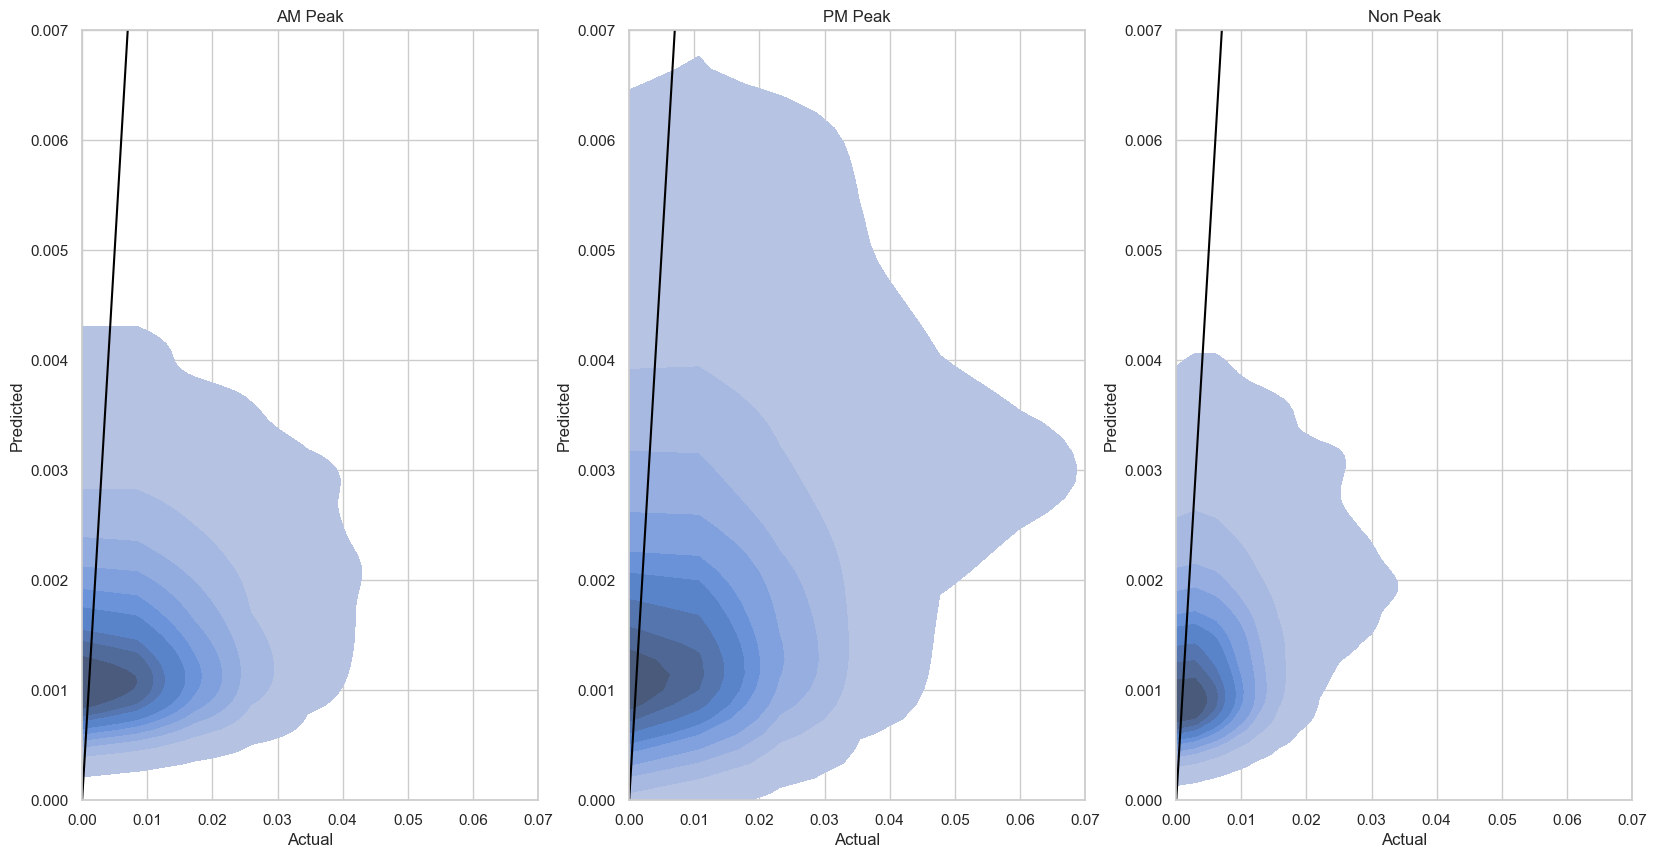

In [33]:
sns.set_theme(style='whitegrid')

fig, axes = plt.subplots(ncols=3, figsize=(20, 10))

axes[0].set_xlim(0, 0.07)
axes[1].set_xlim(0, 0.07)
axes[2].set_xlim(0, 0.07)

axes[0].set_ylim(0, 0.007)
axes[1].set_ylim(0, 0.007)
axes[2].set_ylim(0, 0.007)

axes[0].set_title('AM Peak')
axes[1].set_title('PM Peak')
axes[2].set_title('Non Peak')

axes[0].set_xlabel('Actual')
axes[1].set_xlabel('Actual')
axes[2].set_xlabel('Actual')

axes[0].set_ylabel('Predicted')
axes[1].set_ylabel('Predicted')
axes[2].set_ylabel('Predicted')

sns.kdeplot(x=np.exp(ampeak['Npgrs'].values), y=np.exp(amresult.predict(sm.add_constant(ampeak_final))).values, fill=True, ax=axes[0])
sns.lineplot(x=np.arange(0, 0.1, 0.0001), y=np.arange(0, 0.1, 0.0001), color='black', ax=axes[0])
sns.kdeplot(x=np.exp(pmpeak['Npgrs'].values), y=np.exp(pmresult.predict(sm.add_constant(pmpeak_final))).values, fill=True, ax=axes[1])
sns.lineplot(x=np.arange(0, 0.1, 0.0001), y=np.arange(0, 0.1, 0.0001), color='black', ax=axes[1])
sns.kdeplot(x=np.exp(nonpeak['Npgrs'].values), y=np.exp(nonresult.predict(sm.add_constant(nonpeak_final))).values, fill=True, ax=axes[2])
sns.lineplot(x=np.arange(0, 0.1, 0.0001), y=np.arange(0, 0.1, 0.0001), color='black', ax=axes[2])

## 4. Revision

In [51]:
middle_list = ['Residential_boarding',  'Residential_alighting',  'Commercial_boarding',  'Commercial_alighting',  'Industrial_boarding',  'Industrial_alighting',  'Others_boarding',  'Others_alighting',  'Landuse_Mix_boarding',  'Landuse_Mix_alighting',  'Middle_School_boarding',  'Middle_School_alighting',  'Trunk_boarding',  'Trunk_alighting',  'Feeder_boarding',  'Feeder_alighting',  'Other_Buses_boarding',  'Other_Buses_alighting',  'Subway_Station_boarding',  'Subway_Station_alighting',  'impedance']

In [52]:
str = 'Npgrs~'

for i in middle_list:
    str += i + '+'
    if i == 'impedance':
        str += i

str

'Npgrs~Residential_boarding+Residential_alighting+Commercial_boarding+Commercial_alighting+Industrial_boarding+Industrial_alighting+Others_boarding+Others_alighting+Landuse_Mix_boarding+Landuse_Mix_alighting+Middle_School_boarding+Middle_School_alighting+Trunk_boarding+Trunk_alighting+Feeder_boarding+Feeder_alighting+Other_Buses_boarding+Other_Buses_alighting+Subway_Station_boarding+Subway_Station_alighting+impedance+impedance'

In [54]:
midmodel = sm.OLS.from_formula(str, data=ampeak)
midresult = midmodel.fit()
print(midresult.summary())

                            OLS Regression Results                            
Dep. Variable:                  Npgrs   R-squared:                       0.169
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     79.13
Date:                Wed, 29 Nov 2023   Prob (F-statistic):          2.90e-308
Time:                        19:27:46   Log-Likelihood:                -11015.
No. Observations:                8190   AIC:                         2.207e+04
Df Residuals:                    8168   BIC:                         2.223e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [56]:
midmodel = sm.OLS.from_formula(str, data=pmpeak)
midresult = midmodel.fit()
print(midresult.summary())

                            OLS Regression Results                            
Dep. Variable:                  Npgrs   R-squared:                       0.249
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     128.7
Date:                Wed, 29 Nov 2023   Prob (F-statistic):               0.00
Time:                        19:28:08   Log-Likelihood:                -11506.
No. Observations:                8190   AIC:                         2.306e+04
Df Residuals:                    8168   BIC:                         2.321e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [53]:
midmodel = sm.OLS.from_formula(str, data=nonpeak)
midresult = midmodel.fit()
print(midresult.summary())

                            OLS Regression Results                            
Dep. Variable:                  Npgrs   R-squared:                       0.146
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     66.50
Date:                Wed, 29 Nov 2023   Prob (F-statistic):          2.40e-260
Time:                        19:27:24   Log-Likelihood:                -12059.
No. Observations:                8190   AIC:                         2.416e+04
Df Residuals:                    8168   BIC:                         2.432e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [59]:
high_list = ['Residential_boarding',  'Residential_alighting',  'Commercial_boarding',  'Commercial_alighting',  'Industrial_boarding',  'Industrial_alighting',  'Others_boarding',  'Others_alighting',  'Landuse_Mix_boarding',  'Landuse_Mix_alighting', 'High_School_boarding', 'High_School_alighting',  'Trunk_boarding',  'Trunk_alighting',  'Feeder_boarding',  'Feeder_alighting',  'Other_Buses_boarding',  'Other_Buses_alighting',  'Subway_Station_boarding',  'Subway_Station_alighting',  'impedance']

In [60]:
str = 'Npgrs~'

for i in high_list:
    str += i + '+'
    if i == 'impedance':
        str += i

str

'Npgrs~Residential_boarding+Residential_alighting+Commercial_boarding+Commercial_alighting+Industrial_boarding+Industrial_alighting+Others_boarding+Others_alighting+Landuse_Mix_boarding+Landuse_Mix_alighting+High_School_boarding+High_School_alighting+Trunk_boarding+Trunk_alighting+Feeder_boarding+Feeder_alighting+Other_Buses_boarding+Other_Buses_alighting+Subway_Station_boarding+Subway_Station_alighting+impedance+impedance'

In [61]:
highmodel = sm.OLS.from_formula(str, data=ampeak)
highresult = highmodel.fit()
print(highresult.summary())

                            OLS Regression Results                            
Dep. Variable:                  Npgrs   R-squared:                       0.179
Model:                            OLS   Adj. R-squared:                  0.177
Method:                 Least Squares   F-statistic:                     84.71
Date:                Wed, 29 Nov 2023   Prob (F-statistic):               0.00
Time:                        19:28:47   Log-Likelihood:                -10966.
No. Observations:                8190   AIC:                         2.198e+04
Df Residuals:                    8168   BIC:                         2.213e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [62]:
highmodel = sm.OLS.from_formula(str, data=pmpeak)
highresult = highmodel.fit()
print(highresult.summary())

                            OLS Regression Results                            
Dep. Variable:                  Npgrs   R-squared:                       0.253
Model:                            OLS   Adj. R-squared:                  0.251
Method:                 Least Squares   F-statistic:                     131.8
Date:                Wed, 29 Nov 2023   Prob (F-statistic):               0.00
Time:                        19:28:47   Log-Likelihood:                -11482.
No. Observations:                8190   AIC:                         2.301e+04
Df Residuals:                    8168   BIC:                         2.316e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [63]:
highmodel = sm.OLS.from_formula(str, data=nonpeak)
highresult = highmodel.fit()
print(highresult.summary())

                            OLS Regression Results                            
Dep. Variable:                  Npgrs   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.148
Method:                 Least Squares   F-statistic:                     68.75
Date:                Wed, 29 Nov 2023   Prob (F-statistic):          5.67e-269
Time:                        19:28:48   Log-Likelihood:                -12039.
No. Observations:                8190   AIC:                         2.412e+04
Df Residuals:                    8168   BIC:                         2.428e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               